In [1]:
import numpy as np
import tensorflow as tf
import sklearn.metrics

2023-12-12 04:18:44.940298: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# uncomment, to enable GPU
#tf.config.set_visible_devices([], 'GPU')

In [3]:
BATCH_SIZE  = 32
TOTAL_EPOCH = 2

In [ ]:
IMAGE_SIZE = (256, 256)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory('./path/to/train/set', label_mode= "categorical", image_size = IMAGE_SIZE, shuffle = True,  batch_size = BATCH_SIZE)
tests_dataset = tf.keras.utils.image_dataset_from_directory('./path/to/test/set',  label_mode= "categorical", image_size = IMAGE_SIZE, shuffle = False, batch_size = 1)
valid_dataset = tf.keras.utils.image_dataset_from_directory('./path/to/val/set',   label_mode= "categorical", image_size = IMAGE_SIZE, shuffle = True,  batch_size = BATCH_SIZE)

Found 711 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 63 files belonging to 2 classes.


2023-12-12 04:19:09.930320: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.CenterCrop(224, 224),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [8]:
# define model here !

inputs  = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x       = data_augmentation(inputs)
x       = tf.keras.layers.Conv2D(16, 5,  activation = "LeakyReLU")(inputs)
x       = tf.keras.layers.MaxPool2D()(x)
x       = tf.keras.layers.Conv2D(32, 3,  activation = "LeakyReLU")(x)
x       = tf.keras.layers.MaxPool2D()(x)
x       = tf.keras.layers.Conv2D(64, 3,  activation = "LeakyReLU")(x)
x       = tf.keras.layers.MaxPool2D()(x)
x       = tf.keras.layers.Flatten()(x)
x       = tf.keras.layers.Dense(64, activation = "ReLU")(x)
outputs = tf.keras.layers.Dense(2)(x)

model = tf.keras.Model(inputs, outputs)

In [9]:
model.compile(optimizer = 'adam',
              loss      = tf.keras.losses.CategoricalCrossentropy(),
              metrics   = ['accuracy'])

In [10]:
save_best_callback = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath        = './model-ml.h5', 
        save_best_only  = True, 
        monitor         = 'val_accuracy',
        mode            = 'max')
]

model.fit(
        train_dataset,
        epochs = TOTAL_EPOCH,
        validation_data = valid_dataset,
        callbacks = save_best_callback
)

Epoch 1/2
23/23 [==============================] - 19s 809ms/step - loss: 0.9338 - accuracy: 0.5499 - val_loss: 0.6899 - val_accuracy: 0.5397
Epoch 2/2
23/23 [==============================] - 18s 787ms/step - loss: 0.6852 - accuracy: 0.5429 - val_loss: 0.6839 - val_accuracy: 0.5397


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        18496 

In [12]:
best_ml = tf.keras.models.load_model('./model-ml.h5')
predictions = best_ml.predict(tests_dataset)

104/104 [==============================] - 2s 14ms/step


In [13]:
predicions_args = np.argmax(predictions, axis= 1)
print(predicions_args[:10], predicions_args.shape)

[0 0 0 0 0 0 0 0 0 0] (104,)


In [14]:
ground_truth_lables_argmx = np.array([np.argmax(y, axis = 1)[0] for x, y in tests_dataset])
print(ground_truth_lables_argmx[:10], ground_truth_lables_argmx.shape)

[0 0 0 0 0 0 0 0 0 0] (104,)


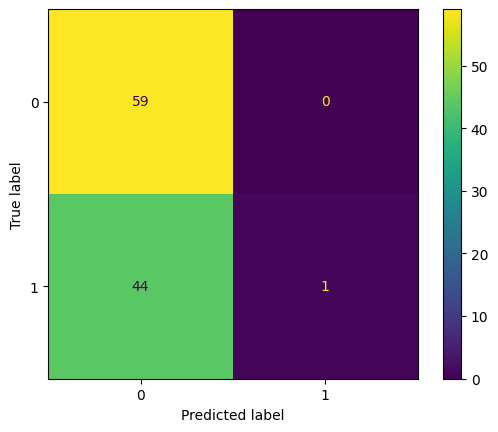

In [15]:
cm = sklearn.metrics.confusion_matrix(ground_truth_lables_argmx, predicions_args)    
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [16]:
print(sklearn.metrics.classification_report(ground_truth_lables_argmx, predicions_args))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        59
           1       1.00      0.02      0.04        45

    accuracy                           0.58       104
   macro avg       0.79      0.51      0.39       104
weighted avg       0.76      0.58      0.43       104

